In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 14494480343520806349
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11320098816
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 1229225032833911937
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
 xla_global_id: 416903419]

In [174]:
df_main = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/HealthCare/hungary_chickenpox.csv')
df_main.head()

,Date,BUDAPEST,BARANYA,BACS,BEKES,BORSOD,CSONGRAD,FEJER,GYOR,HAJDU,HEVES,JASZ,KOMAROM,NOGRAD,PEST,SOMOGY,SZABOLCS,TOLNA,VAS,VESZPREM,ZALA
0,03/01/2005,168,79,30,173,169,42,136,120,162,36,130,57,2,178,66,64,11,29,87,68
1,10/01/2005,157,60,30,92,200,53,51,70,84,28,80,50,29,141,48,29,58,53,68,26
2,17/01/2005,96,44,31,86,93,30,93,84,191,51,64,46,4,157,33,33,24,18,62,44
3,24/01/2005,163,49,43,126,46,39,52,114,107,42,63,54,14,107,66,50,25,21,43,31
4,31/01/2005,122,78,53,87,103,34,95,131,172,40,61,49,11,124,63,56,7,47,85,60


In [175]:
df_main.shape

(522, 21)

In [ ]:
df_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 522 entries, 0 to 521
Data columns (total 21 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Date      522 non-null    object
 1   BUDAPEST  522 non-null    int64 
 2   BARANYA   522 non-null    int64 
 3   BACS      522 non-null    int64 
 4   BEKES     522 non-null    int64 
 5   BORSOD    522 non-null    int64 
 6   CSONGRAD  522 non-null    int64 
 7   FEJER     522 non-null    int64 
 8   GYOR      522 non-null    int64 
 9   HAJDU     522 non-null    int64 
 10  HEVES     522 non-null    int64 
 11  JASZ      522 non-null    int64 
 12  KOMAROM   522 non-null    int64 
 13  NOGRAD    522 non-null    int64 
 14  PEST      522 non-null    int64 
 15  SOMOGY    522 non-null    int64 
 16  SZABOLCS  522 non-null    int64 
 17  TOLNA     522 non-null    int64 
 18  VAS       522 non-null    int64 
 19  VESZPREM  522 non-null    int64 
 20  ZALA      522 non-null    int64 
dtypes: int64(20), ob

In [176]:
df = df_main[['Date','BUDAPEST']]
time = pd.date_range(start='1/3/2005',periods=522,freq='W')
df['time_stamp'] = pd.DataFrame(time)
df.drop(['Date'],axis=1,inplace=True)
df = df.set_index('time_stamp')

In [ ]:
df.min()

BUDAPEST    0
dtype: int64

In [177]:
df = df + 1

In [ ]:
df.head()

,BUDAPEST
time_stamp,
2005-01-09,169
2005-01-16,158
2005-01-23,97
2005-01-30,164
2005-02-06,123


In [ ]:
df.tail()

,BUDAPEST
time_stamp,
2014-12-07,96
2014-12-14,44
2014-12-21,36
2014-12-28,31
2015-01-04,260


In [178]:
plt.rcParams['figure.figsize'] = [15,8]

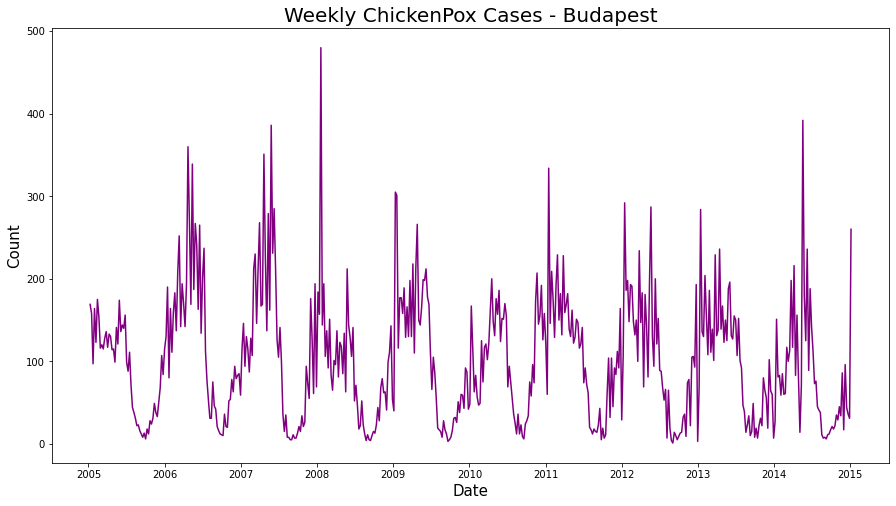

In [ ]:
plt.plot(df,color='purple')
plt.title('Weekly ChickenPox Cases - Budapest',fontsize=20)
plt.xlabel('Date',fontsize=15)
plt.ylabel('Count',fontsize=15)
plt.show()

In [191]:
def convert2matrix(data_arr, look_back):
    X, Y =[], []
    for i in range(len(data_arr)-look_back):
        d=i+look_back  
        X.append(data_arr[i:d,0])
        Y.append(data_arr[d,0])
    return np.array(X), np.array(Y)

In [192]:
from sklearn.preprocessing import MinMaxScaler
#create numpy.ndarray 
df['BUDAPEST'] = df['BUDAPEST'].astype(np.float32)
df_arr = df.values
df_arr = np.reshape(df_arr, (-1, 1))
scaler = MinMaxScaler(feature_range=(0.1, 1))
df_arr = scaler.fit_transform(df_arr)

In [193]:
#Split data set into testing dataset and train dataset
train_size = 469
train, test =df_arr[0:train_size,:], df_arr[train_size:len(df_arr),:]
# setup look_back window 
look_back = 3
#convert dataset into right shape in order to input into the DNN
trainX, trainY = convert2matrix(train, look_back)
testX, testY = convert2matrix(test, look_back)

In [194]:
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

(466, 3)
(466,)
(50, 3)
(50,)


In [ ]:
!pip install -q -U keras-tuner

     |████████████████████████████████| 98 kB 4.1 MB/s 


In [ ]:
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from keras_tuner.tuners import RandomSearch
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.layers import Flatten
import matplotlib.pyplot as plt

In [ ]:
def build_model(hp):
    model = keras.Sequential()
    for i in range(hp.Int('num_layers', 1, 6)):
        model.add(layers.Dense(units=hp.Int('units_' + str(i),
                                            min_value=8,
                                            max_value = 128,
                                            step=8),
                                            activation= "relu"))
        if hp.Boolean("dropout"):
          model.add(Dropout(hp.Float('Dropout_rate',min_value=0,max_value=0.5,step=0.1)))
    model.add(layers.Dense(1, activation='linear'))
    model.compile(
        optimizer=keras.optimizers.Adam(
             hp.Float('learning_rate', min_value=1e-4, max_value=1e-1, sampling="log")),
        loss='mae',
        metrics=['mae'])
    return model

In [ ]:
tuner = RandomSearch(
    build_model,
    objective='val_mae',
    max_trials=10,
    executions_per_trial=1,
    directory='project',
    project_name='loa_em_2')

In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 6, 'step': 1, 'sampling': None}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 128, 'step': 8, 'sampling': None}
dropout (Boolean)
{'default': False, 'conditions': []}
learning_rate (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.1, 'step': None, 'sampling': 'log'}


In [ ]:
tuner.search(trainX, trainY,
             epochs=200,
             batch_size=36,
             validation_data=(testX, testY))

Trial 10 Complete [00h 00m 21s]
val_mae: 0.0788184255361557

Best val_mae So Far: 0.07174060493707657
Total elapsed time: 00h 02m 58s
INFO:tensorflow:Oracle triggered exit


In [ ]:
tuner.results_summary()

Results summary
Results in project/loa_em_2
Showing 10 best trials
Objective(name='val_mae', direction='min')
Trial summary
Hyperparameters:
num_layers: 5
units_0: 16
dropout: True
learning_rate: 0.003076424424430825
units_1: 96
units_2: 112
Dropout_rate: 0.2
units_3: 8
units_4: 48
units_5: 32
Score: 0.07174060493707657
Trial summary
Hyperparameters:
num_layers: 3
units_0: 112
dropout: False
learning_rate: 0.0005795398295497946
units_1: 112
units_2: 40
Dropout_rate: 0.4
units_3: 112
units_4: 16
units_5: 24
Score: 0.07295935600996017
Trial summary
Hyperparameters:
num_layers: 1
units_0: 128
dropout: False
learning_rate: 0.0007665367128892476
Score: 0.07390383630990982
Trial summary
Hyperparameters:
num_layers: 6
units_0: 72
dropout: True
learning_rate: 0.0016094689354460446
units_1: 16
units_2: 48
Dropout_rate: 0.0
units_3: 8
units_4: 8
units_5: 8
Score: 0.07396408915519714
Trial summary
Hyperparameters:
num_layers: 1
units_0: 24
dropout: False
learning_rate: 0.00015816535860465057
unit

In [ ]:
from warnings import filterwarnings
filterwarnings('ignore')

In [ ]:
models = tuner.get_best_models(num_models=2)
best_model = models[0]
# Build the model.
# Needed for `Sequential` without specified `input_shape`.
best_model.build(input_shape=(None, 12))
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                208       
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 96)                1632      
                                                                 
 dropout_1 (Dropout)         (None, 96)                0         
                                                                 
 dense_2 (Dense)             (None, 112)               10864     
                                                                 
 dropout_2 (Dropout)         (None, 112)               0         
                                                                 
 dense_3 (Dense)             (None, 8)                 9

In [ ]:
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping

In [195]:
model = Sequential()
model.add(Dense(128,activation='relu',input_dim = 3))
model.add(Dropout(0.2))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1,activation='linear'))
ad=optimizers.Adam(learning_rate = 0.0000176424424430825)
model.compile(optimizer = ad, loss = 'mae', metrics = ['mae','mape'])
model_history=model.fit(trainX, trainY,validation_data=(testX,testY), batch_size = 36, epochs = 700)

Epoch 1/700
13/13 [==============================] - 1s 21ms/step - loss: 0.3292 - mae: 0.3292 - mape: 112.9334 - val_loss: 0.2779 - val_mae: 0.2779 - val_mape: 109.4126
Epoch 2/700
13/13 [==============================] - 0s 4ms/step - loss: 0.3284 - mae: 0.3284 - mape: 111.8987 - val_loss: 0.2717 - val_mae: 0.2717 - val_mape: 106.5587
Epoch 3/700
13/13 [==============================] - 0s 4ms/step - loss: 0.3169 - mae: 0.3169 - mape: 108.9866 - val_loss: 0.2658 - val_mae: 0.2658 - val_mape: 103.8170
Epoch 4/700
13/13 [==============================] - 0s 4ms/step - loss: 0.3135 - mae: 0.3135 - mape: 106.7887 - val_loss: 0.2599 - val_mae: 0.2599 - val_mape: 101.1262
Epoch 5/700
13/13 [==============================] - 0s 4ms/step - loss: 0.3058 - mae: 0.3058 - mape: 103.6061 - val_loss: 0.2542 - val_mae: 0.2542 - val_mape: 98.4625
Epoch 6/700
13/13 [==============================] - 0s 4ms/step - loss: 0.3001 - mae: 0.3001 - mape: 101.5451 - val_loss: 0.2485 - val_mae: 0.2485 - val_m

In [196]:
def model_loss(history):
    plt.figure(figsize=(8,4))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Test Loss')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.legend(loc='upper right')
    plt.show();

In [197]:
trainX_2 = scaler.inverse_transform(trainX)
trainY_2 = scaler.inverse_transform([trainY])
testX_2 = scaler.inverse_transform(testX)
testY_2 = scaler.inverse_transform([testY])
train_score_2 = model.evaluate(trainX_2, trainY_2.reshape(-1,),verbose=0)
test_score_2 = model.evaluate(testX_2, testY_2.reshape(-1,),verbose=0)

Train MAE : 35.74 
Test MAE : 37.72 


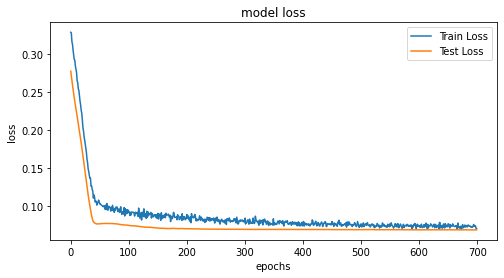

In [198]:
train_predict = model.predict(trainX)
test_predict = model.predict(testX)

# invert predictions
train_predict = scaler.inverse_transform(train_predict)
trainY = scaler.inverse_transform([trainY])
test_predict = scaler.inverse_transform(test_predict)
testY = scaler.inverse_transform([testY])
print('Train MAE : %.2f ' % (train_score_2[1]))
print('Test MAE : %.2f ' % (test_score_2[1]))
model_loss(model_history)

In [157]:
import seaborn as sns

In [200]:
def prediction_plot(testY, test_predict,look_back):
    len_prediction=[x for x in range(466,516)]
    plt.plot(trainY.reshape(-1,))
    plt.plot(len_prediction, testY.reshape(-1,), marker='.', label='actual')
    plt.plot(len_prediction, test_predict, 'g', label="prediction")
    plt.tight_layout()
    sns.despine(top=True)
    plt.subplots_adjust(left=0.07)
    plt.ylabel('Units', size=15)
    plt.xlabel('Time step', size=15)
    plt.legend(fontsize=15)
    plt.show()

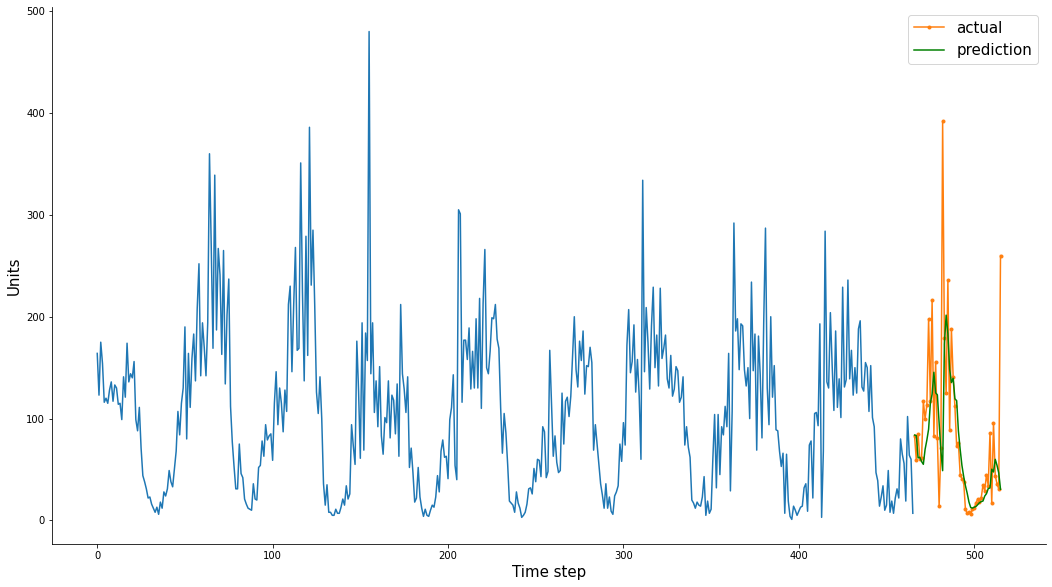

In [201]:
test_predict = model.predict(testX)
test_predict = scaler.inverse_transform(test_predict)
prediction_plot(testY, test_predict,look_back)

In [202]:
from sklearn.metrics import mean_absolute_error as mae

In [203]:
print(mae(testY.reshape(-1,),test_predict.reshape(-1,)))

36.654270052552334
